# Make multiwavelength light curves using archival data
***

## Learning Goals    
By the end of this tutorial, you will be able to:
 - automatically load a catalog of sources
 - automatically search NASA and non-NASA resources for light curves
 - store light curves in a Pandas multiindex dataframe
 - plot all light curves on the same plot
 
 
## Introduction:
 - A user has a sample of interesting targets for which they would like to see a plot of available archival light curves.  We start with a small set of changing look AGN from Yang et al., 2018, which are automatically downloaded. Changing look AGN are cases where the broad emission lines appear or disappear (and not just that the flux is variable). 
 - We model light curve plots after van Velzen et al. 2021.  We search through a curated list of time-domain NASA holdings as well as non-NASA sources.  HEASARC catalogs used are Fermi and Beppo-Sax, IRSA catalogs used are ZTF and WISE, and MAST catalogs used are Pan-Starrs, TESS, Kepler, and K2.  Non-NASA sources are Gaia and IceCube. This list is generalized enough to include many types of targets to make this notebook interesting for many types of science.  All of these time-domain archives are searched in an automated fashion using astroquery or APIs.
 - Light curve data storage is a tricky problem.  Currently we are using a multi-index Pandas dataframe, as the best existing choice for right now.  One downside is that we need to manually track the units of flux and time instead of relying on an astropy storage scheme which would be able to do some of the units worrying for us (even astropy can't do all magnitude to flux conversions).  Astropy does not currently have a good option for multi-band light curve storage.
 - We intend to explore a ML classifier for these changing look AGN light curves.
 
## Input:
 - choose from a list of known changing look AGN from the literature
 
  OR - 
 - input your own sample

## Output:
 - an archival optical + IR + neutrino light curve
 
## Technical Goals:
 - should be able to run from a clean checkout from github
 - should be able to automatically download all catalogs & images used
 - need to have all photometry in the same physical unit
 - need to have a data structure that is easy to use but holds light curve information (time and units) and is extendable to ML applications
 - need to have a curated list of catalogs to search for photometry that is generalizeable to other input catalogs
 
## Non-standard Imports:
- `astroquery` to interface with archives APIs
- `astropy` to work with coordinates/units and data structures
- `lightkurve` to search TESSS, Kepler, and K2 archives
- `urllib` to handle archive searches with website interface
- `acstools` to work with HST magnitude to flux conversion
- `unTimely` to retrieve WISE light curves
- `alerce` to convert ZTF object names into coordinates

## Authors:
IPAC SP team

## Acknowledgements:
Suvi Gezari, Antara Basu-zych,Stephanie LaMassa\
MAST, HEASARC, & IRSA Fornax teams



In [ ]:
import numpy as np
import time
import pandas as pd
import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import requests
import pickle

from scipy import stats

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, name_resolve
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import fits,ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries

try:
    from tqdm import tqdm
except ImportError:
    !pip install tqdm
    from tqdm import tqdm

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try:
    import lightkurve as lk
except ImportError:
    !pip install lightkurve --upgrade
    import lightkurve as lk
        
try:
    from acstools import acszpt
except ImportError:
    !pip install acstools
    from acstools import acszpt

import warnings
warnings.filterwarnings('ignore')

try:
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
except ImportError:
    if not os.path.exists('./unTimely_Catalog_explorer'):
        !git clone https://github.com/fkiwy/unTimely_Catalog_explorer.git
    sys.path.append('./unTimely_Catalog_explorer')
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
    

!pip install alerce


import tempfile

# Local code imports
sys.path.append('code/')
from fluxconversions import convert_WISEtoJanskies, convertACSmagtoflux
from panstarrs import panstarrs_get_lightcurves, ps1cone, ps1search, checklegal, ps1metadata, addfilter, improve_filter_format, search_lightcurve
from clean_filternames import clean_filternames
from gaia_functions import Gaia_retrieve_EPOCH_PHOTOMETRY, Gaia_mk_lightcurves, Gaia_mk_MultiIndex
from HCV_functions import get_hscapiurl, hcvcone, hcvsearch, hcvmetadata, cat2url, checklegal_hcv, HCV_get_lightcurves
from mast_functions import resolve, mastQuery
from icecube_functions import get_icecube_catalog
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, \
    get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample,  get_SDSS_sample, remove_duplicate_coords
from ztf_functions import ZTF_id2coord,ZTF_get_lightcurve
from data_structures import MultiIndexDFObject
from heasarc_functions import HEASARC_get_lightcurves
from TESS_Kepler_functions import TESS_Kepler_get_lightcurves
from WISE_functions import WISE_get_lightcurves

## Plotting stuff
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelpad'] = 7
mpl.rcParams['xtick.major.pad'] = 7
mpl.rcParams['ytick.major.pad'] = 7
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['hatch.linewidth'] = 1



## NEW! LOAD/SAVE PICKLE FILE! ##
SAVEDF = False # if set to True, pickle file will be saved. If False, pickle file will be loaded.
pickle_file_name = "data/dflc_Shooby_March102023.pkl" # name of pickle file (to be loaded or saved)
#pickle_file_name = "data/dflc_Krick_Feb232023.pkl" # name of pickle file (to be loaded or saved)
###


In [ ]:
### Initialize Pandas MultiIndex data frame for storing the light curve
df_lc = MultiIndexDFObject()

## 1. Define the Sample
 We define here a "gold" sample of spectroscopically confirmed changing look AGN and quasars. This sample includes both objects which change from type 1 to type 2 and also the opposite.  Future studies may want to treat these as seperate objects or seperate QSOs from AGN.
 
 Bibcodes for the samples used are listed next to their functions for reference.  
 
 Functions used to grab the samples from the papers use Astroquery, NED, SIMBAD, Vizier, and in a few cases grab the tables from the html versions of the paper.

In [5]:
#build up the sample
coords =[]
labels = []

#choose your own adventure:

#get_lamassa_sample(coords, labels)  #2015ApJ...800..144L
#get_macleod16_sample(coords, labels) #2016MNRAS.457..389M
#get_ruan_sample(coords, labels) #2016ApJ...826..188R
#get_macleod19_sample(coords, labels)  #2019ApJ...874....8M
#get_sheng_sample(coords, labels)  #2020ApJ...889...46S
#get_green_sample(coords, labels)  #2022ApJ...933..180G
#get_lyu_sample(coords, labels)  #z32022ApJ...927..227L
#get_lopeznavas_sample(coords, labels)  #2022MNRAS.513L..57L
#get_hon_sample(coords, labels)  #2022MNRAS.511...54H
get_yang_sample(coords, labels)   #2018ApJ...862..109Y

#now get some "normal" QSOs for use in the classifier
#there are ~500K of these, so choose the number based on
#a balance between speed of running the light curves and whatever 
#the ML algorithms would like to have

num_normal_QSO = 100 
#get_SDSS_sample(coords, labels, num_normal_QSO)

#remove duplicates from the list if combining multiple references
coords_list, labels_list = remove_duplicate_coords(coords, labels)

#add an index-like list with our own object name
object_name = [['CLAGN' + str(i)] for i in range(len(coords_list))]
print('sample size: '+str(len(coords_list)))

### 1.1 Build your own Sample

To build your own sample, you can follow the examples of functions above to grab coordinates from your favorite literature resource, 

or

You can use [astropy's read](https://docs.astropy.org/en/stable/io/ascii/read.html) function to read in an input table
and then convert that table into a list of [skycoords](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) 

## 2. Find light curves for these targets in NASA catalogs
  - We search a curated list of time-domain catalogs from all NASA archives


### 2.1 HEASARC: FERMI & Beppo SAX


In [ ]:
mission_list = ['FERMIGTRIG', 'SAXGRBMGRB']
radius = 0.1*u.degree

#go out and find all light curves in the above curated list which match our target positions
df_lc = HEASARC_get_lightcurves(df_lc, coords_list,radius, mission_list)

### 2.2 IRSA: ZTF

In [ ]:
df_lc = ZTF_get_lightcurve(df_lc,coords_list,labels_list,plotprint=1) ## number of plots to show to be set by plotprint

### 2.3 IRSA:WISE

- use the unTimely catalog which ties together all WISE & NEOWISE 2010 - 2020 epochs.  Specifically it combined all observations at a single epoch to achieve deeper mag limits than individual observations alone.
- https://github.com/fkiwy/unTimely_Catalog_explorer
- https://iopscience-iop-org.caltech.idm.oclc.org/article/10.3847/1538-3881/aca2ab

In [ ]:
bandlist = ['w1', 'w2']
radius = 1.0

df_lc = WISE_get_lightcurves(df_lc, coords_list, labels_list, radius, bandlist)

### 2.4 MAST: Pan-STARRS
Query the Pan-STARRS API; based on this [example](https://ps1images.stsci.edu/ps1_dr2_api.html)

In [ ]:
#Do a panstarrs search
radius = 1.0/3600.0    # search radius = 1 arcsec
df_lc = panstarrs_get_lightcurves(df_lc, coords_list, labels_list, radius)

In [ ]:
#get a look at what that multiindex data frame looks like so far
df_lc.data


### 2.5 MAST: Asteroid Terrestrial-impact Last Alert System (ATLAS)
 - All-sky stellar reference catalog 
 -  MAST hosts this catalog but there are three barriers to using it
     1. it is unclear if the MAST [holdings]( https://archive.stsci.edu/hlsp/atlas-refcat2#section-a737bc3e-2d56-4827-9ab4-838fbf8d67c1) include the individual epoch photometry and 
     2. it is only accessible with casjobs, not through python notebooks.  
     3. magnitude range (g, r, i) < 19mag makes it not relevant for this use case
 
One path forward if this catalog becomes scientifically interesting is to put in a MAST helpdesk ticket to see if 1) they do have the light curves, and 2) they could switch the catalog to a searchable with python version.  There are some ways of [accessing casjobs with python](<https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/HSC/HCV_CASJOBS/HCV_casjobs_demo.ipynb), but not this particular catalog.  
 

### 2.6 MAST: TESS, Kepler and K2
 - use [`lightKurve`](https://docs.lightkurve.org/index.html) to search all 3 missions and download light curves
 


In [ ]:
#go get the lightcurves using lightkurve
radius = 1.0  #arcseconds
df_lc = TESS_Kepler_get_lightcurves(df_lc, coords_list, labels_list, radius)

### 2.7 MAST: HCV
 - [hubble catalog of variables](https://archive.stsci.edu/hlsp/hcv) 
 - using [this notebook](https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html) as a reference to search and download light curves via API

In [ ]:
#Do an HCV search
radius = 1.0/3600.0 # radius = 1 arcsec
df_lc = HCV_get_lightcurves(df_lc, coords_list, labels_list, radius)

## 3. Find light curves for these targets in relevant, non-NASA catalogs


### 3.1 Gaia 


In [ ]:
############ EXTRACT GAIA DATA FOR OBJECTS ##########
## Note: This is very slow. Can probably make faster with direct SQL search?

## Select Gaia table (DR3)
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

## Define search radius
radius = u.Quantity(20, u.arcsec)

## Search and Cross match.
# This can be done in a smarter way by matching catalogs on the Gaia server, or grouping the
# sources and search a larger area.

# get catalog
gaia_table = Table()
t1 = time.time()
for cc,coord in enumerate(coords_list):
    print(len(coords_list)-cc , end=" ")

    gaia_search = Gaia.cone_search_async(coordinate=coord, radius=radius , background=True)
    gaia_search.get_data()["dist"].unit = "deg"
    gaia_search.get_data()["dist"] = gaia_search.get_data()["dist"].to(u.arcsec) # Change distance unit from degrees to arcseconds

    
    # match
    if len(gaia_search.get_data()["dist"]) > 0:
        #gaia_search.get_data()["input_object_name"] = CLAGN["Object Name"][cc] # add input object name to catalog
        gaia_search.get_data()["input_object_name"] = object_name[cc] # add input object name to catalog
        gaia_search.get_data()["input_object_id"] = object_name[cc] # add input object name to catalog
        sel_min = np.where( (gaia_search.get_data()["dist"] < 1*u.arcsec) & (gaia_search.get_data()["dist"] == np.nanmin(gaia_search.get_data()["dist"]) ) )[0]
    else:
        sel_min = []
        
    #print("Number of sources matched: {}".format(len(sel_min)) )
    
    if len(sel_min) > 0:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )
    else:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )

print("\nSearch completed in {:.2f} seconds".format((time.time()-t1) ) )
print("Number of objects mached: {} out of {}.".format(len(gaia_table),len(object_name) ) )

In [ ]:
%%time
########## EXTRACT PHOTOMETRY #########
# Once we matched the objects, we have to extract the photometry for them. Here we extract
# the mean photometry (later we will do the time series).
# Note that the fluxes are in e/s, not very useful. However, there are magnitudes (what unit??) but without errors.
# We can get the errors from the flux errors?
# Also note that we should include the source_id in order to search for epoch photometry

## Define keys (columns) that will be used later. Also add wavelength in angstroms for each filter
other_keys = ["source_id","phot_g_n_obs","phot_rp_n_obs","phot_bp_n_obs"] # some other useful info
mag_keys = ["phot_bp_mean_mag" , "phot_g_mean_mag" , "phot_rp_mean_mag"]
magerr_keys = ["phot_bp_mean_mag_error" , "phot_g_mean_mag_error" , "phot_rp_mean_mag_error"]
flux_keys = ["phot_bp_mean_flux" , "phot_g_mean_flux" , "phot_rp_mean_flux"]
fluxerr_keys = ["phot_bp_mean_flux_error" , "phot_g_mean_flux_error" , "phot_rp_mean_flux_error"]
mag_lambda = ["5319.90" , "6735.42" , "7992.90"]

## Get photometry. Note that this includes only objects that are 
# matched to the catalog. We have to add the missing ones later.
_phot = gaia_table[mag_keys]
_err = hstack( [ 2.5/np.log(10) * gaia_table[e]/gaia_table[f] for e,f in zip(fluxerr_keys,flux_keys) ] )
gaia_phot2 = hstack( [_phot , _err] )

## Clean up (change units and column names)
_ = [gaia_phot2.rename_column(f,m) for m,f in zip(magerr_keys,fluxerr_keys)]
for key in magerr_keys:
    gaia_phot2[key].unit = "mag"
gaia_phot2["input_object_name"] = gaia_table["input_object_name"].copy()

## Add Some other useful information
for key in other_keys:
    gaia_phot2[key] = gaia_table[key]


## Also add object for which we don't have photometry.
# Add Nan for now, need to think about proper format. Also, there are probably smarter ways to do this.
# We do this by matching the object names from the original catalog to the photometry catalog. Then add
# an entry [np.nan, ...] if it does not exist. To make life easier, we add a dummy entry as the first
# row so we can compy all the 
gaia_phot = Table( names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
for ii in range(len(object_name)):
    #sel = np.where( CLAGN["Object Name"][ii] == gaia_phot2["input_object_name"] )[0]
    sel = np.where( object_name[ii] == gaia_phot2["input_object_name"] )[0]
    if len(sel) > 0:
        gaia_phot = vstack([gaia_phot , gaia_phot2[sel] ])
    else:
        tmp = Table( np.repeat(np.NaN , len(gaia_phot2.keys())) , names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
        gaia_phot = vstack([gaia_phot , tmp ])
        
## Some cleanup:
gaia_phot["source_id"][gaia_phot["source_id"] < 0] = 0

In [ ]:
%%time
######## EXTRACT LIGHT CURVES ##########
# Now since we have matched the objects to the Gaia catalog, we can also extract the full light curves using
# the Gaia IDs.

## Log in (apparently not necessary for small queries) =========
#Gaia.login(user=None , password=None)


## For each of the objects, request the EPOCH_PHOTOMETRY from the Gaia DataLink Service =======

## Run search
ids = list(gaia_phot["source_id"])
prod_tab = Gaia_retrieve_EPOCH_PHOTOMETRY(ids=ids , verbose=False)

## Create light curves
gaia_epoch_phot = Gaia_mk_lightcurves(prod_tab)

## Create MultiBandTimeSeries photometry object (not used anymore)
#gaia_multibandTS_phot = Gaia_mk_MultibandTimeSeries(epoch_phot = gaia_epoch_phot)

## Create Gaia Pandas MultiIndex object and append to existing data frame.
df_lc_gaia = Gaia_mk_MultiIndex(data=object_name,labels_list=labels_list , gaia_phot=gaia_phot , gaia_epoch_phot=gaia_epoch_phot , verbose = 1)

## Append to existing MultiIndex object (if exists)
#df_lc = MultiIndexDFObject()
df_lc.append(df_lc_gaia)


In [ ]:
### MAKE FIGURE OF ONE LIGHT CURVE FOR GAIA ###

## First get the ids/names of sources that have Gaia multi-epoch observations.
object_ids = list(df_lc.data.index.levels[0]) # get list of objectids in multiIndex table
print(object_ids)

fig = plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
axs = [ fig.add_subplot(1,3,ii+1) for ii in range(3) ]
cmap = plt.get_cmap("Spectral")

for dd in object_ids:
    try:
    
        for bb,band in enumerate(["G","BP","RP"]):
        
            this_tab = df_lc.data.loc[dd,:,"Gaia {}".format(band.lower()),:].reset_index(inplace=False)
            t = Time(this_tab["time"] , format="mjd") # convert to time object
            #axs[bb].plot(t.mjd , this_tab["flux"] , "-" , linewidth=1 , markersize=0.1)
            axs[bb].errorbar(t.mjd , this_tab["flux"] , yerr=this_tab["err"] , fmt="-o",linewidth=0.5 , markersize=3 , label="{}".format(dd))
    except:
        pass

for ii in range(3):
    axs[ii].set_title(np.asarray(["G","BP","RP"])[ii])
    axs[ii].legend(fontsize=6 , ncol=3)
    axs[ii].set_xlabel("MJD (Days)" , fontsize=10)
    axs[ii].set_ylabel(r"Flux ($\mu$Jy)", fontsize=10)

plt.show()

### 3.2 ASAS-SN (all sky automated survey for supernovae) 
- Has a [website](https://asas-sn.osu.edu/photometry) that can be manually searched; but no API which would allow automatic searches from within this notebook
- Magnitude range of this survey is not consistent with the magnitude range of our CLAGN.  If this catalog becomes scientifically interesting, one path forward would be to ask ASAS-SN team about implementing an API



### 3.3 Icecube Neutrinos

There are several [catalogs](https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018) (basically one for each year of IceCube data from 2008 - 2018). The following code creates a large catalog by combining
all the yearly catalogs.
The IceCube catalog contains Neutrino detections with associated energy and time and approximate direction (which is uncertain by half-degree scales....). Usually, for active events only one or two Neutrinos are detected, which makes matching quite different compared to "photons". For our purpose, we will list the top 3 events in energy that are within a given distance to the target.

This time series (time vs. neutrino energy) information is similar to photometry. We choose to storing time and energy in our data structure, leaving error = 0. What is __not__ stored in this format is the distance or angular uncertainty of the event direction. 

In [ ]:
%%time
#### LOAD EVENTS ####
# This loads the IceCube catalog, which is dispersed in different files.
# Each file has a list of events with their energy, time, and approximate direction.
icecube_events , _ = get_icecube_catalog(path="./data/icecube/icecube_10year_ps/")

# sort by Neutrino energy
icecube_events.sort(keys="energy_logGeV" , reverse=True)

In [ ]:
### MATCH OBJECTS ###
# Here we match the objects to the IceCube catalog to extract the N highest energy events close
# to the objects' coordinates. We also want to include the errors in position of the IceCube
# events.

## Top N (in energy) events to selected
icecube_select_topN = 3

## create SkyCoord objects from event coordinates
c2 = SkyCoord(icecube_events["ra"], icecube_events["dec"], unit="deg", frame='icrs')

## Match
icecube_matches = []
icecube_matched = []
ii = 0
for cc,coord in enumerate(coords_list):

    # get all distances
    dist_angle =  coord.separation(c2)
    
    # make selection: here we have to also include errors on the
    # angles somehow.
    sel = np.where( (dist_angle.to(u.degree).value - icecube_events["AngErr"]) <= 0.0)[0]
    #print(len(sel))

    # select the top N events in energy. Note that we already sorted the table
    # by energy_logGeV. Hence we only have to pick the top N here.
    if len(sel) < icecube_select_topN:
        this_topN = len(sel)
    else:
        this_topN = icecube_select_topN * 1
    
    if len(sel) > 0:
        icecube_matches.append(icecube_events[sel[0:this_topN]])
        icecube_matches[ii]["Ang_match"] = dist_angle.to(u.degree).value[sel[0:this_topN]]
        icecube_matches[ii]["Ang_match"].unit = u.degree
        icecube_matched.append(cc)
        
        ii += 1
        
        
    else:
        pass # no match found
        print("No match found.")

        
## Add to lightcurve object:
ii = 0
for cc,coord in enumerate(tqdm(coords_list)):
    lab = labels_list[cc]
    if cc in icecube_matched:
        ## Create single instance
        dfsingle = pd.DataFrame(
                                dict(flux=np.asarray(icecube_matches[ii]["energy_logGeV"]), # in log GeV
                                 err=np.repeat(0,len(icecube_matches[ii])), # in mJy
                                 time=np.asarray(icecube_matches[ii]["mjd"]), # in MJD
                                 #objectid=gaia_phot["input_object_name"][ii],
                                 objectid=np.repeat(cc+1, len(icecube_matches[ii])),label=lab,
                                 band="IceCube"
                                    )
                    ).set_index(["objectid", "label", "band", "time"])

        ## Append
        df_lc.append(dfsingle)
        
        ii += 1
    
print("IceCube Matched and added to lightcurve object.")

In [3]:
# Save or load the data frame
if SAVEDF:
    df_lc.pickle(pickle_file_name)
    print("Pickle file saved!")
else:
    df_lc = MultiIndexDFObject()
    #df_lc.load_pickle("data/dflc.pkl")
    df_lc.load_pickle(pickle_file_name)
    print("Pickle file loaded!")

Pickle file loaded!


## 4. Make plots of luminosity as a function of time
- model plots after [van Velzen et al., 2021](https://arxiv.org/pdf/2111.09391.pdf)


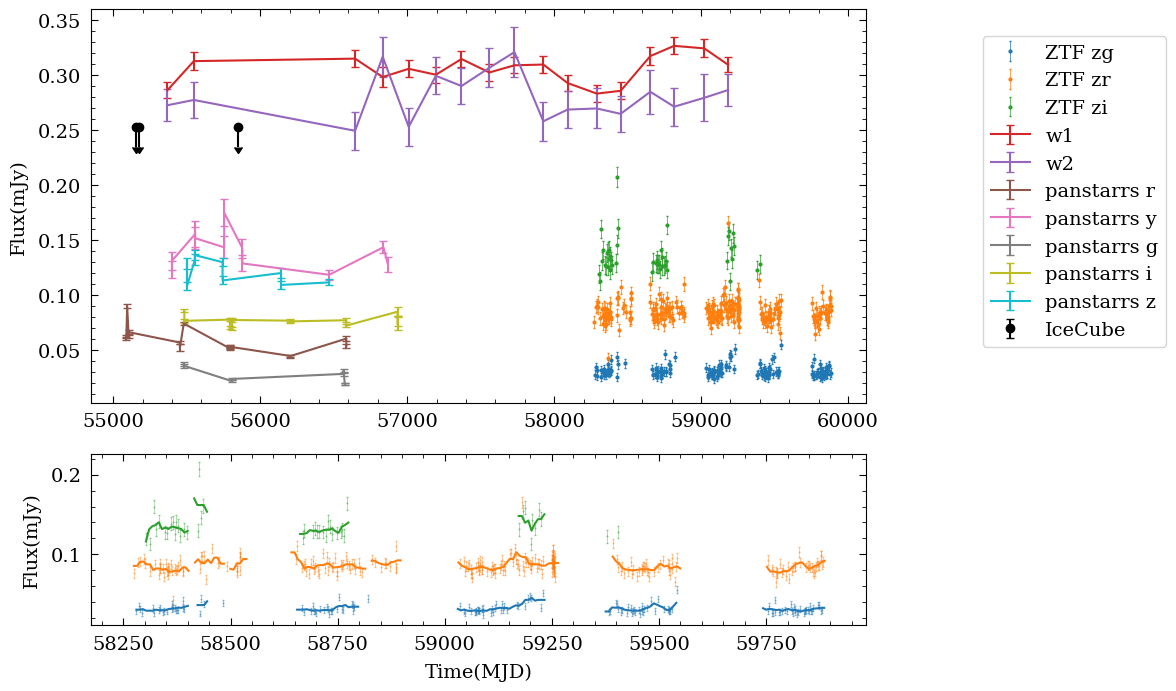

CPU times: user 1.11 s, sys: 14.9 ms, total: 1.12 s
Wall time: 1.13 s


In [72]:
%%time

for ccount, coord in enumerate(coords_list[2:3]):
    singleobj = df_lc.data.loc[(ccount+1),:,:]

    # Set up for plotting. We use the "mosaic" method so we can plot
    # the ZTF data in a subplot for better visibility.
    fig, axes = plt.subplot_mosaic(mosaic=[["A"],["A"],["B"]] , figsize=(10,8))
    plt.subplots_adjust(hspace=0.3 , wspace=0.3)

    # First check to see which bands we have in the dataframe
    availband = singleobj.index.unique('band')
    

    # Plot all the bands in the *main plot* (A)
    leg_handles_A = []
    max_list = [] # store maximum flux for each band
    ztf_minmax_tab = Table(names=["tmin","tmax","fluxmin","fluxmax"]) # store the min and max of the ZTF band fluxes and time
    has_ztf = False # flag to set to True if ZTF data is available.
    for l in range(len(availband)):
        band_lc = singleobj.loc[ccount+1,:, availband[l], :]
        #band_lc = singleobj.loc[availband[l], :] # above line doesn't work for me [ALF]
        band_lc.reset_index(inplace = True)

        # first clean dataframe to remove erroneous rows
        band_lc_clean = band_lc[band_lc['time'] < 65000]
        
        #before plotting need to scale the Kepler, K2, and TESS fluxes to the other available fluxes
        if availband[l] in ['Kepler', 'K2', 'TESS']: # Note: these are not included anymore...
            #remove outliers in the dataset
            bandlc_clip = band_lc_clean[(np.abs(stats.zscore(band_lc_clean['flux'])) < 3.0)]

            #find the maximum value of 'other bands'
            max_electrons = max(band_lc_clean.flux)
            factor = np.mean(max_list)/ max_electrons
            lh = axes["A"].errorbar(bandlc_clip.time, bandlc_clip.flux * factor, bandlc_clip.err* factor,
                                    capsize = 3.0,label = availband[l])
        elif availband[l] in ['zg','zr','zi']: # for ZTF
            has_ztf = True
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5,marker='o',markersize=2,linestyle='', label = "ZTF {}".format(availband[l]))
            ztf_minmax_tab.add_row( [np.min(band_lc_clean.time) , np.max(band_lc_clean.time) , np.min(band_lc_clean.flux) , np.max(band_lc_clean.flux) ] )
            
            
            # plot ZTF in zoomin
            p1 = axes["B"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5, marker='o',linestyle='',markersize=0.5, alpha=0.5,
                                    label = "ZTF {}".format(availband[l]))
            
            # overplot running mean fo ZTF in zoomin 
            xx = band_lc_clean.time
            yy = band_lc_clean.flux
            ee = band_lc_clean.err
            x_bin = 30 # in MJD
            x_grid = np.arange(np.nanmin(xx) , np.nanmax(xx)+x_bin/4 , x_bin/4)
            tmp = Table(names=["xbin","ybin","yerr"])
            for xxx in x_grid:
                s = np.where( np.abs(xx - xxx) < x_bin/2 )[0]
                if len(s) > 1:
                    mn = np.nansum(yy[s]*ee[s]) / np.nansum(ee[s]) # weighted mean
                    tmp.add_row([xxx , mn , np.nanstd(yy[s])])
                else:
                    #pass
                    tmp.add_row([xxx , np.nan , np.nan])
            axes["B"].plot(tmp["xbin"] , tmp["ybin"] , "-", linewidth=1.5 , color=p1.lines[0].get_color())
            
        elif availband[l] in ["IceCube"]: # IceCube (no fluxes, just events)
            y = axes["A"].get_ylim()[0] + np.diff(axes["A"].get_ylim())*0.7
            dy = np.diff(axes["A"].get_ylim())/20
            lh = axes["A"].errorbar(band_lc_clean.time , np.repeat(y , len(band_lc_clean.time)) , yerr=dy, uplims=True ,
                                    fmt="o"  , label=availband[l] , color="black")
            
        else: # everything else
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 3.0, label = availband[l])

        leg_handles_A.append(lh)
    
    # Plot the ZTF bands in a separate plot to show their variability
    # more clearly. Can still also plot the rest, just change the x and
    # y axis limits. Only do this if ZTF is available for source.

    ## Do Axes
    
    #axes["A"].spines['top'].set_visible(False)
    #axes["A"].spines['right'].set_visible(False)
    axes["A"].set_ylabel('Flux(mJy)')
    
    if has_ztf:
        axes["B"].set_ylabel('Flux(mJy)')
        axes["B"].set_xlabel('Time(MJD)')

        axes["B"].set_xlim( np.min(ztf_minmax_tab["tmin"])-100 , np.max(ztf_minmax_tab["tmax"])+100 )
    
    
    plt.legend(handles=leg_handles_A , bbox_to_anchor=(1.4,3.5))
    plt.tight_layout()
    #save the plot to data/*.pdf
    savename = "data/lightcurve_{}.pdf".format(ccount+1)
    plt.savefig(savename, bbox_inches="tight")
    plt.show()
    
## TODO:
## - add running median to ZTF lightcurve. [ALF]


## ML Extension 
Consider training a ML model to do light curve classification based on this sample of CLAGN
 - once we figure out which bands these are likely to be observed in, could then have a optical + IR light curve classifier
 - what would the features of the light curve be?
 - what models are reasonable to test as light curve classifiers?
 - could we make also a sample of TDEs, SNe, flaring AGN? - then train the model to distinguish between these things?
 - need a sample of non-flaring light curves
 
After training the model:
 - would then need a sample of optical + IR light curves for "all" galaxies = big data to run the model on.

Some resources to consider:
- https://github.com/dirac-institute/ZTF_Boyajian
- https://ui.adsabs.harvard.edu/abs/2022AJ....164...68S/abstract
- https://ui.adsabs.harvard.edu/abs/2019ApJ...881L...9F/abstract



## References

This work made use of:

- Astroquery; Ginsburg et al., 2019, 2019AJ....157...98G

- Astropy; Astropy Collaboration 2022, Astropy Collaboration 2018, Astropy Collaboration 2013, 2022ApJ...935..167A, 2018AJ....156..123A, 2013A&A...558A..33A

- Lightkurve; Lightkurve Collaboration 2018, 2018ascl.soft12013L

- acstools; https://zenodo.org/record/7406933#.ZBH1HS-B0eY

- unTimely; Meisner et al., 2023, 2023AJ....165...36M

- Alerce; Forster et al., 2021, 2021AJ....161..242F